In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [51]:
def generate_graph_form_adjecency_matrix(adjacency_matrix: np.ndarray, mylabels: list[str], connection_cutoff: float = 0.3) -> nx.Graph:
    rows, cols = np.where(abs(adjacency_matrix) >= connection_cutoff)
    graph = nx.Graph()
    all_rows = range(0, adjacency_matrix.shape[0])
    for n in all_rows:
        graph.add_node(n)
    for row, column in zip(rows, cols):
        weight = adjacency_matrix[row, column]
        graph.add_edge(row, column, weight=weight)
    nx.draw(graph, node_size=900, labels=mylabels, with_labels=True)
    plt.show()
    return graph

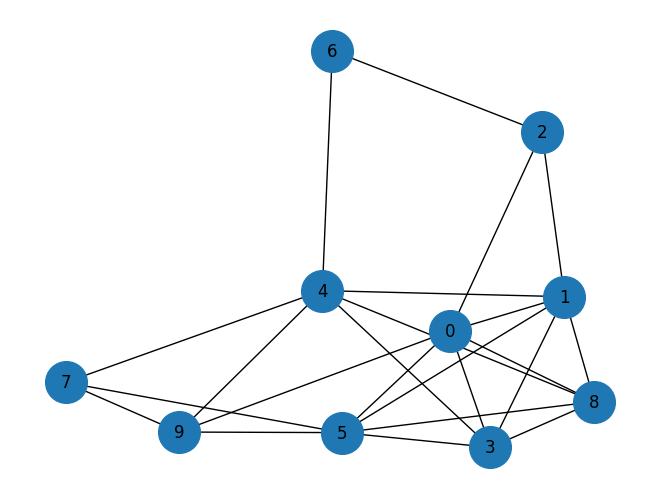

Graph Graph with 10 nodes and 23 edges


In [52]:
N = 10
example_correlation_matrix = np.random.random(size=(N,N))
example_correlation_matrix = (example_correlation_matrix + example_correlation_matrix.T)/2
np.fill_diagonal(example_correlation_matrix, 0.0)

graph = generate_graph_form_adjecency_matrix(example_correlation_matrix, mylabels={i: str(i) for i in range(N)}, connection_cutoff=0.5)
print("Graph", graph)